In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy import stats
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip, RandomRotation, BatchNormalization, SpatialDropout2D
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from tensorflow.keras.metrics import BinaryCrossentropy as metricBinaryCrossentropy
from tensorflow.keras.metrics import FalseNegatives, BinaryIoU ,AUC#, F1Score
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Nadam ,schedules
from tensorflow.image import resize_with_crop_or_pad
from tensorflow import cast, expand_dims, float32, random
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Import data and labels


In [3]:
data_path = './blind_cameras_dataset'
#neutrino-01 path: '/storage/gpfs_data/neutrino/SAND-LAr/SAND-LAr-OPTICALSIM-PROD/GRAIN/blindcam/data'

# Load Data 
# with open(data_path+'/simulation_0.npy', 'rb') as a:    #'+str(sim_num)+'
#     data_in_0 = np.load(a)  
with open(data_path+'/simulation_11.npy', 'rb') as b:    #'+str(sim_num)+'
    data_in_1 = np.load(b)
# with open(data_path+'/simulation_25.npy', 'rb') as c:    #'+str(sim_num)+'
#     data_in_25 = np.load(c)
with open(data_path+'/simulation_22.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_2 = np.load(c)
    
# Load MC Truth
# with open(data_path+'/inner_ph_0.npy', 'rb') as e:      #'+str(sim_num)+'
#     ph_in_0 = np.load(e)
with open(data_path+'/inner_ph_11.npy', 'rb') as f:      #'+str(sim_num)+'
    ph_in_1 = np.load(f)
# with open(data_path+'/inner_ph_25.npy', 'rb') as g:      #'+str(sim_num)+'
#     ph_in_25 = np.load(g)
with open(data_path+'/inner_ph_22.npy', 'rb') as g:      #'+str(sim_num)+'
    ph_in_2 = np.load(g)

### Reshaping data_0

In [4]:
# d0 = data_in_0.reshape(-1, 31, 31 )
# new_data_0 = np.array(resize_with_crop_or_pad(d0.T.reshape(31,31,-1), 32, 32)).T
# new_data_0.shape

### Concatenating multiple datasets

In [5]:
###### fixed parameters ###########
n_cam_in_grain_0 = 54
n_cam_in_grain_1 = 58
n_cam_in_grain_2 = 60
cam_side_length = 32
###################################

# inner_ph_in_0 = ph_in_0[:,0].reshape(n_cam_in_grain_0, -1)
inner_ph_in_1 = ph_in_1[:,0].reshape(n_cam_in_grain_1, -1)
inner_ph_in_2 = ph_in_2[:,0].reshape(n_cam_in_grain_2, -1)

# inner_ratio_0 = (ph_in_0[:,0]/ph_in_0[:,1]).reshape(n_cam_in_grain_0, -1)
inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
inner_ratio_2 = (ph_in_2[:,0]/ph_in_2[:,1]).reshape(n_cam_in_grain_2, -1)

# new_data_0 = new_data_0.reshape(-1, cam_side_length**2)
data_in_1 = data_in_1.reshape(-1, cam_side_length**2)
data_in_2 = data_in_2.reshape(-1, cam_side_length**2)

data_in = np.concatenate((data_in_1, data_in_2)) #new_data_0, 
inner_ph_in = np.concatenate((np.ravel(inner_ph_in_1, order='F'), np.ravel(inner_ph_in_2, order='F'))) #np.ravel(inner_ph_in_0, order='F'), 
inner_ratio = np.concatenate((np.ravel(inner_ratio_1, order='F'), np.ravel(inner_ratio_2, order='F'))) #np.ravel(inner_ratio_0, order='F'), 

inner_ratio[np.isnan(inner_ratio)] = 0
# data_in = data_in_1 #new_data_0
# inner_ph_in = np.ravel(inner_ph_in_1, order='F')

C:\Users\Pc\AppData\Local\Temp\ipykernel_22484\4186550209.py:13: RuntimeWarning: invalid value encountered in divide
  inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_22484\4186550209.py:14: RuntimeWarning: invalid value encountered in divide
  inner_ratio_2 = (ph_in_2[:,0]/ph_in_2[:,1]).reshape(n_cam_in_grain_2, -1)


### Label data

labelled-blind cameras : 376


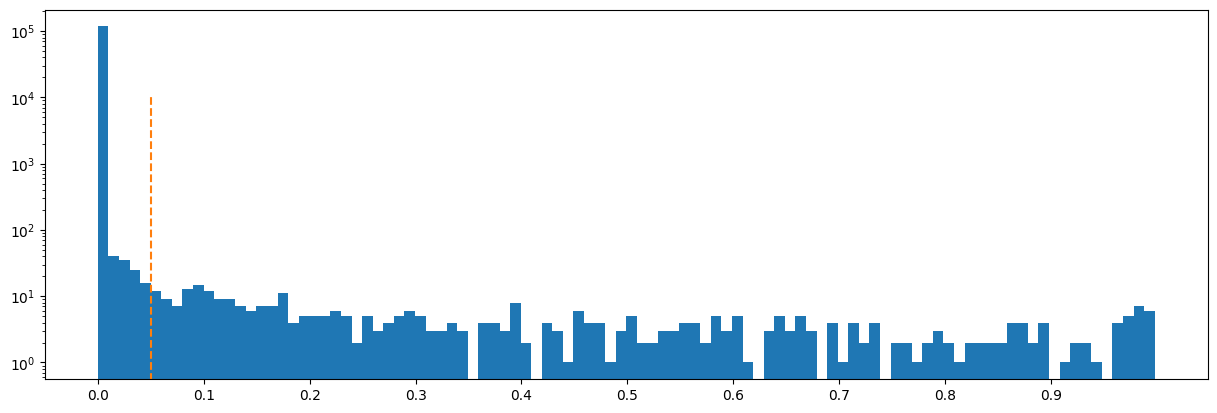

In [6]:
###### parameters #################
ph_threshold = 50                 #
ratio_threshold = 0.05            #
###################################

label = np.zeros(inner_ph_in.shape[0])

for i in np.where( (inner_ratio > ratio_threshold) & (inner_ph_in > ph_threshold) )[0]:
    label[i] = 1
    
n_blind = label[label==1].shape[0]
n_not_blind = label[label==0].shape[0]
print('labelled-blind cameras :', n_blind)

# add pixel saturation
data_in[data_in > 1000] = 1000

fig = plt.figure()
plt.hist(inner_ratio, 100)
plt.yscale('log')
plt.xticks(np.arange(0, 1, 0.1))
plt.plot([ratio_threshold, ratio_threshold],[0,1e4], '--')
fig.set_figwidth(15)

### Feature Extraction

C:\Users\Pc\AppData\Local\Temp\ipykernel_22484\3364313035.py:5: RuntimeWarning: invalid value encountered in divide
  data_ratio = 1 - data_mean/data_max


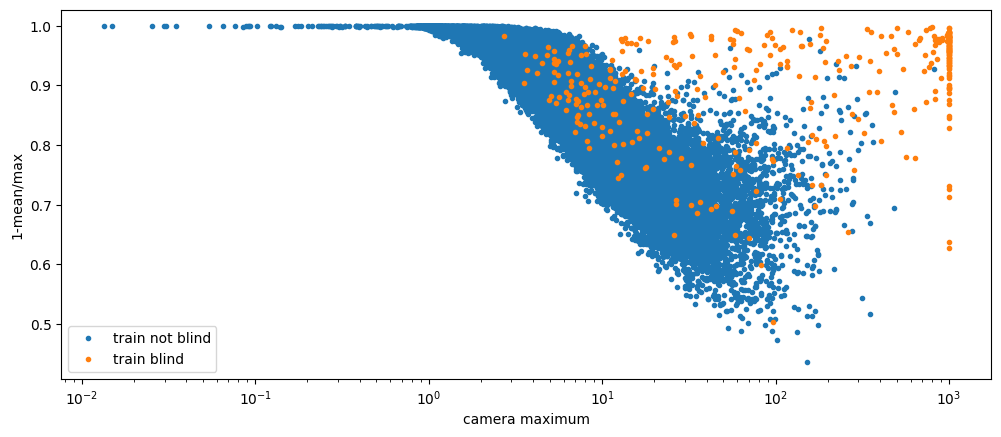

In [7]:
data_amp = np.sum(data_in.reshape(-1, cam_side_length**2), axis=1)
data_max = np.max(data_in.reshape(-1, cam_side_length**2), axis=1)
data_mean = np.mean(data_in.reshape(-1, cam_side_length**2), axis=1)

data_ratio = 1 - data_mean/data_max

# plt.plot(lab_not_bl_max, 1-ratio_not_bl_lab, '.', label='lab not blind')
#ax[0].plot(lab_bl_max, 1-ratio_bl_lab, 'o', label='lab blind')
plt.figure().set_figwidth(12)
plt.plot(data_max[label == 0], data_ratio[label == 0], '.', label='train not blind')
plt.plot(data_max[label == 1], data_ratio[label == 1], '.', label='train blind')

# ax[0].yscale('log')
plt.xscale('log')
plt.xlabel('camera maximum')
plt.ylabel('1-mean/max')
plt.legend()

### Preprocessing

#### Apply RobustScaler

In [8]:
# scaler_ = RobustScaler().fit(data_in)
# scaler_data = scaler_.transform(data_in)#.reshape(-1, n_cam_in_grain, cam_side_length**2)
# #scaler_data = RobustScaler().fit_transform(data_in)

In [9]:
normalize_ = np.max(data_in, axis = 1) #np.max(data.reshape(-1, cam_side_length**2), axis = 1)
normalize_[np.where(normalize_ == 0)[0]] = 1e-5
#normalize_data = (scaler_data / (normalize_.reshape(-1,1)*np.ones((1, cam_side_length**2)))).reshape(-1, cam_side_length**2)#.reshape(-1, n_cam_in_grain, cam_side_length**2) #data
normalize_data = (data_in / (normalize_.reshape(-1,1)*np.ones((1, cam_side_length**2)))).reshape(-1, cam_side_length**2)#.reshape(-1, n_cam_in_grain, cam_side_length**2) #data
normalize_data.shape

(118000, 1024)

In [10]:
# e = 2000

# fig, ax = plt.subplots(1,2)
# d = ax[0].imshow(data_in[e].reshape(32,32))
# n = ax[1].imshow(normalize_data[e].reshape(32,32))
# plt.colorbar(d)
# plt.colorbar(n)
# fig.set_figwidth(15)

In [11]:
# REASON WHY WE ADOPTED THE TECHNIQUE OF RESHAPING INNER PH ARRAY AND THE RAVEL IT WITH "order='F'"

#cam = 7
#evn = 6
#pix = 8
#ip = [ c1(e1,e2,e3,...), c2(e1,e2,e3,...), c3(), c(4), ... ]
#d.reshape = [ e1(c1 - pix)
#              e1(c2 - pix)
#              e1(c3 - pix)
#              e1( ....) 
#              ...
#              e2(c1 - pix)
#              e2(c2 - pix)
#              e2(...)
#              ...
#              e3(...)
# ]

#### UNCOMMENT ONLY THE FOLLOWING LINES #####################################à

# ip = np.array([1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7])
# d = np.array([1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7])
# print(d.reshape(-1,8).shape)
# print(ip.shape)

# ip = ip.reshape(7,6)
# #print(d.reshape(-1,8))
# print(np.ravel(ip, order='F'))

In [12]:
# EXPLAINATION OF HOW TO PROPERLY PAD 31X31 ARRAY 

# ip = np.array([1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7])
# d0 = np.array([1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,
#               1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7])

# d = d0.reshape(-1,8,7)
# dr = np.array(resize_with_crop_or_pad(d.T.reshape(7,8,-1), 8, 9))
# print(d.shape)
# print(dr.T.shape)

#### Split into test and training sets

In [13]:
sep = int(data_in.shape[0] * 0.8)

train_data, test_data = normalize_data[:sep], normalize_data[sep:] #normalize_data[:800], normalize_data[800:]
train_label, test_label = label[:sep], label[sep:]

print(train_data.shape)
print(train_label.shape)

(94400, 1024)
(94400,)


## Data augmentation

In [14]:
# data_augmentation = Sequential([
#   RandomFlip("horizontal_and_vertical"),
#   RandomRotation(0.2),
# ])

# # Add the image to a batch.
# image = cast(expand_dims(train_data[200], 0), float32)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   augmented_image = data_augmentation(image)
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_image[0])
#   plt.axis("off")

In [15]:
train_blind = train_data[np.where(train_label==1)]
train_not_blind = train_data[np.where(train_label==0)]

rdm = np.random.default_rng(12345)
rdm_x = rdm.integers(low=0, high=31, size=int(0.3*n_not_blind))
rdm_y = rdm.integers(low=0, high=31, size=int(0.3*n_not_blind))
artificial_train_blind = np.repeat(train_blind, int(0.3*n_not_blind/train_blind.shape[0]), axis=0).reshape(-1, cam_side_length, cam_side_length, 1)
for r in range(artificial_train_blind.shape[0]) :
    artificial_train_blind[r] = np.roll(artificial_train_blind[r], (rdm_x[r] ,rdm_y[r]), axis=(2,1))
    
artificial_train_label = np.ones(artificial_train_blind.shape[0])

In [16]:
train_data = train_data.reshape(-1, cam_side_length, cam_side_length, 1)
test_data = test_data.reshape(-1, cam_side_length, cam_side_length, 1)

# train_data /= renormalisation
# test_data /= renormalisation

# train_label = train_label.flatten()
# test_label = test_label.flatten()

train_data = np.append(artificial_train_blind, train_data, axis=0)
train_label = np.append(artificial_train_label, train_label)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# data_to_shuffle = np.column_stack((train_data.reshape(-1, cam_side_length**2), train_label))
# print(data_to_shuffle.shape)
# print(train_label.shape)
# print(train_data.reshape(-1, cam_side_length**2).shape)
#train_data = random.shuffle(train_data, 25)

train_label_ohe = to_categorical(train_label,2)
test_label_ohe = to_categorical(test_label,2)

train_label_ohe.shape

(129488, 2)

## CNN model


In [17]:
# lr_schedule = schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
# #optimizer = Nadam(learning_rate=lr_schedule)

In [30]:
#create model
model = Sequential()
#add model layers
model.add(Input(shape=(cam_side_length, cam_side_length, 1)))
#model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=3, activation='relu')) #input_shape=(cam_side_length, cam_side_length, 1)
#model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.3))              
model.add(Conv2D(64, kernel_size=3, activation='relu'))
#model.add(Conv2D(64, kernel_size=3, activation='relu'))
# model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
model.add(Conv2D(128, kernel_size=3, activation='relu'))    #eliminate?
# model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))     #eliminate?
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))  #softmax

In [31]:
#compile model using accuracy to measure model performance
model.compile(optimizer=Nadam(learning_rate=0.001), loss=BinaryCrossentropy(from_logits=False), metrics=[F1Score(num_classes=2)]) #AUC() F1Score(num_classes=2)  #SparseCategoricalCrossentropy(from_logits=True) BinaryCrossentropy(from_logits=True)
                                                                                        #'binary_crossentropy''categorical_crossentropy'
                                                                                        #metrics=[metricBinaryCrossentropy(from_logits=True)] 'binary_accuracy'
                                                                                        # FalseNegatives(thresholds=0)
                                                                                        # BinaryIoU(target_class_ids=[0, 1], threshold=0.7)

#model.summary()

# Train the model
#with tf.device('/device:GPU:0'):
with tf.device('/CPU:0'):
    history_callback = model.fit(train_data, train_label_ohe, batch_size=256, validation_split=0.25, epochs= 30) #validation_data=(test_data, test_label_ohe)  #_ohe
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#pd.DataFrame(history_callback.history).plot(logy=True)

Epoch 1/30
380/380 [==============================] - 48s 118ms/step - loss: 0.2356 - f1_score: 0.8951 - val_loss: 0.2232 - val_f1_score: 0.5051
Epoch 2/30
380/380 [==============================] - 44s 116ms/step - loss: 0.0728 - f1_score: 0.9723 - val_loss: 0.0859 - val_f1_score: 0.5738
Epoch 3/30
380/380 [==============================] - 44s 117ms/step - loss: 0.0350 - f1_score: 0.9871 - val_loss: 0.1296 - val_f1_score: 0.5409
Epoch 4/30
380/380 [==============================] - 46s 120ms/step - loss: 0.0220 - f1_score: 0.9923 - val_loss: 0.0431 - val_f1_score: 0.6646
Epoch 5/30
380/380 [==============================] - 46s 121ms/step - loss: 0.0159 - f1_score: 0.9946 - val_loss: 0.0476 - val_f1_score: 0.6498
Epoch 6/30
380/380 [==============================] - 47s 124ms/step - loss: 0.0136 - f1_score: 0.9954 - val_loss: 0.0397 - val_f1_score: 0.6655
Epoch 7/30
380/380 [==============================] - 46s 122ms/step - loss: 0.0108 - f1_score: 0.9963 - val_loss: 0.0441 - val_f1

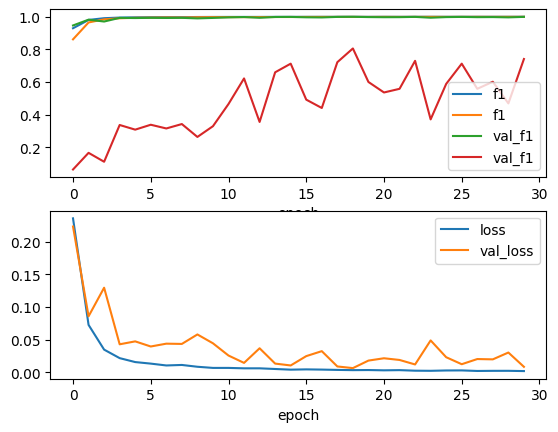

In [32]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history_callback.history['f1_score'], label='f1')
ax[0].plot(history_callback.history['val_f1_score'], label='val_f1')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history_callback.history['loss'], label='loss')
ax[1].plot(history_callback.history['val_loss'], label='val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend()

In [33]:
with tf.device('/CPU:0'):
    test_loss, test_acc = model.evaluate(test_data, test_label_ohe) #ohe?
    print('test_acc:', test_acc)

    pred = model.predict(test_data)
    pred = np.around(pred) 

    pred_dec = np.dot(pred, np.array([0,1], dtype='float32'))
    pred_lab = np.dot(test_label_ohe, np.array([0,1], dtype='float32'))
    cm = confusion_matrix(pred_lab, pred_dec)
    prec = precision_score(pred_lab, pred_dec)
    reca = recall_score(pred_lab, pred_dec)
    f1 = f1_score(pred_lab, pred_dec)
    roc = roc_auc_score(pred_lab, pred_dec)

print('labelled :', np.where(pred_lab==1)[0].size)  
print('predicted :',  np.where(pred_dec==1)[0].size) 
print('true positive :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)).shape[0])     
print('false positive :', np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)).shape[0])     
print('false negative :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)).shape[0]) 
print('\n')
print('confusion matrix :')
print(cm)
print('precision :', prec)
print('recall :', reca)
print('f1 score :', f1)
print('roc score :', roc)
#
#print(np.where(pred_dec==1))
#print(np.where(pred_lab==1))
non_scaled = data_in[sep:].reshape(-1, cam_side_length, cam_side_length, 1)
write_pdf = False
if write_pdf :
    n = 0
    pdf = PdfPages('./cnn_f1_1.pdf')
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)):
        fig, ax = plt.subplots(1,2) #figure()
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix0)
        ax[0].set_title('TRUE positive')
        matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix1)
        ax[1].set_title('TRUE positive')
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)):
        fig, ax = plt.subplots(1,2) #figure()
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix0)
        ax[0].set_title('FALSE positive')
        matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix1)
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)):
        fig, ax = plt.subplots(1,2) #figure()
        fig.set_figwidth(15)
        matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix0)
        ax[0].set_title('FALSE negative')
        matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
        fig.colorbar(matrix1)
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==0)):
        n += 1
        while n < 50:
            fig, ax = plt.subplots(1,2) #figure()
            fig.set_figwidth(15)
            matrix0 = ax[0].pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
            fig.colorbar(matrix0)
            ax[0].set_title('TRUE negative')
            matrix1 = ax[1].pcolormesh(non_scaled[evn].reshape(cam_side_length,cam_side_length)) #*renormalisation
            fig.colorbar(matrix1)
            pdf.savefig(fig)
            plt.close()        
    pdf.close()

738/738 [==============================] - 10s 14ms/step - loss: 0.0343 - f1_score: 0.8110
test_acc: [0.99812627 0.6239316 ]
738/738 [==============================] - 8s 10ms/step
labelled : 104
predicted : 130
true positive : 73
false positive : 57
false negative : 31


confusion matrix :
[[23439    57]
 [   31    73]]
precision : 0.5615384615384615
recall : 0.7019230769230769
f1 score : 0.6239316239316239
roc score : 0.8497485660407009


## Prediction vs MC truth visualization

C:\Users\Pc\AppData\Local\Temp\ipykernel_22484\2370127510.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  pred_bl_mod = stats.mode(pred_bl, axis=1)[0].ravel()
C:\Users\Pc\AppData\Local\Temp\ipykernel_22484\2370127510.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this 

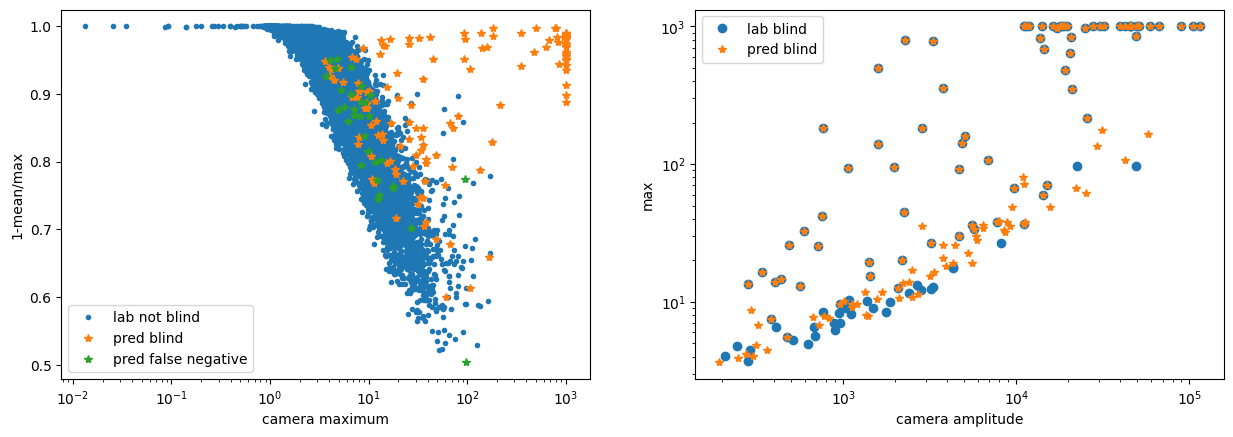

In [34]:
test_d = data_in[sep:]
#test_d = MaxAbsScaler().fit_transform(data_in[sep:])

lab_bl = test_d[np.where(pred_lab==1)]
lab_not_bl = test_d[np.where(pred_lab==0)]
pred_bl = test_d[np.where(pred_dec==1)]
pred_not_bl = test_d[np.where(pred_dec==0)]
pred_fn = test_d[np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0))]

lab_not_bl_amp = np.sum(lab_not_bl, axis=1)
lab_bl_amp = np.sum(lab_bl, axis=1)
pred_bl_amp = np.sum(pred_bl, axis=1)
pred_not_bl_amp = np.sum(pred_not_bl, axis=1)
pred_fn_amp = np.sum(pred_fn, axis=1)
pred_bl_mod = stats.mode(pred_bl, axis=1)[0].ravel()
lab_not_bl_mod = stats.mode(lab_not_bl, axis=1)[0].ravel()
pred_fn_mod = stats.mode(pred_fn, axis=1)[0].ravel()

lab_not_bl_max = np.max(lab_not_bl, axis=1)
lab_bl_max = np.max(lab_bl, axis=1)
pred_bl_max = np.max(pred_bl, axis=1)
pred_not_bl_max = np.max(pred_not_bl, axis=1)
pred_fn_max = np.max(pred_fn, axis=1)

lab_not_bl_mean = np.mean(lab_not_bl, axis=1)
lab_bl_mean = np.mean(lab_bl, axis=1)
pred_bl_mean = np.mean(pred_bl, axis=1)
pred_not_bl_mean = np.mean(pred_not_bl, axis=1)
pred_fn_mean = np.mean(pred_fn, axis=1)

ratio_bl_lab = lab_bl_mean/lab_bl_max
ratio_not_bl_lab = lab_not_bl_mean/lab_not_bl_max
ratio_bl_pred = pred_bl_mean/pred_bl_max
ratio_not_bl_pred = pred_not_bl_mean/pred_not_bl_max
ratio_fn_pred = pred_fn_mean/pred_fn_max

fig, ax = plt.subplots(1,2)
ax[0].plot(lab_not_bl_max, 1-ratio_not_bl_lab, '.', label='lab not blind')
#ax[0].plot(lab_bl_max, 1-ratio_bl_lab, 'o', label='lab blind')
ax[0].plot(pred_bl_max, 1-ratio_bl_pred, '*', label='pred blind')
ax[0].plot(pred_fn_max, 1-ratio_fn_pred, '*', label='pred false negative')
# ax[0].yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('camera maximum')
ax[0].set_ylabel('1-mean/max')
ax[0].legend()

ax[1].plot(lab_bl_amp, lab_bl_max, 'o', label='lab blind')
ax[1].plot(pred_bl_amp, pred_bl_max, '*', label='pred blind')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')
ax[1].set_ylabel('max')
ax[1].legend()

# ax[1,0].plot(lab_not_bl_amp, 1-ratio_not_bl_lab, '.', label='lab not blind')
# #ax[0].plot(lab_bl_max, 1-ratio_bl_lab, 'o', label='lab blind')
# ax[1,0].plot(pred_bl_amp, 1-ratio_bl_pred, '*', label='pred blind')
# ax[1,0].plot(pred_fn_amp, 1-ratio_fn_pred, '*', label='pred false negative')
# # ax[0].yscale('log')
# ax[1,0].set_xscale('log')
# ax[1,0].set_xlabel('camera amplitude')
# ax[1,0].set_ylabel('1-mean/max')
# ax[1,0].legend()

# ax[1,1].plot(lab_not_bl_mod, lab_not_bl_max, '.', label='lab not blind')
# ax[1,1].plot(pred_bl_mod, pred_bl_max, '*', label='pred blind')
# ax[1,1].plot(pred_fn_mod, pred_fn_max, '*', label='pred false negative')

# ax[1,1].set_yscale('log')
# ax[1,1].set_xscale('log')
# ax[1,1].set_xlabel('camera mode')
# ax[1,1].set_ylabel('camera max')
# ax[1,1].legend()

fig.set_figwidth(15)
# fig.set_figheight(10)

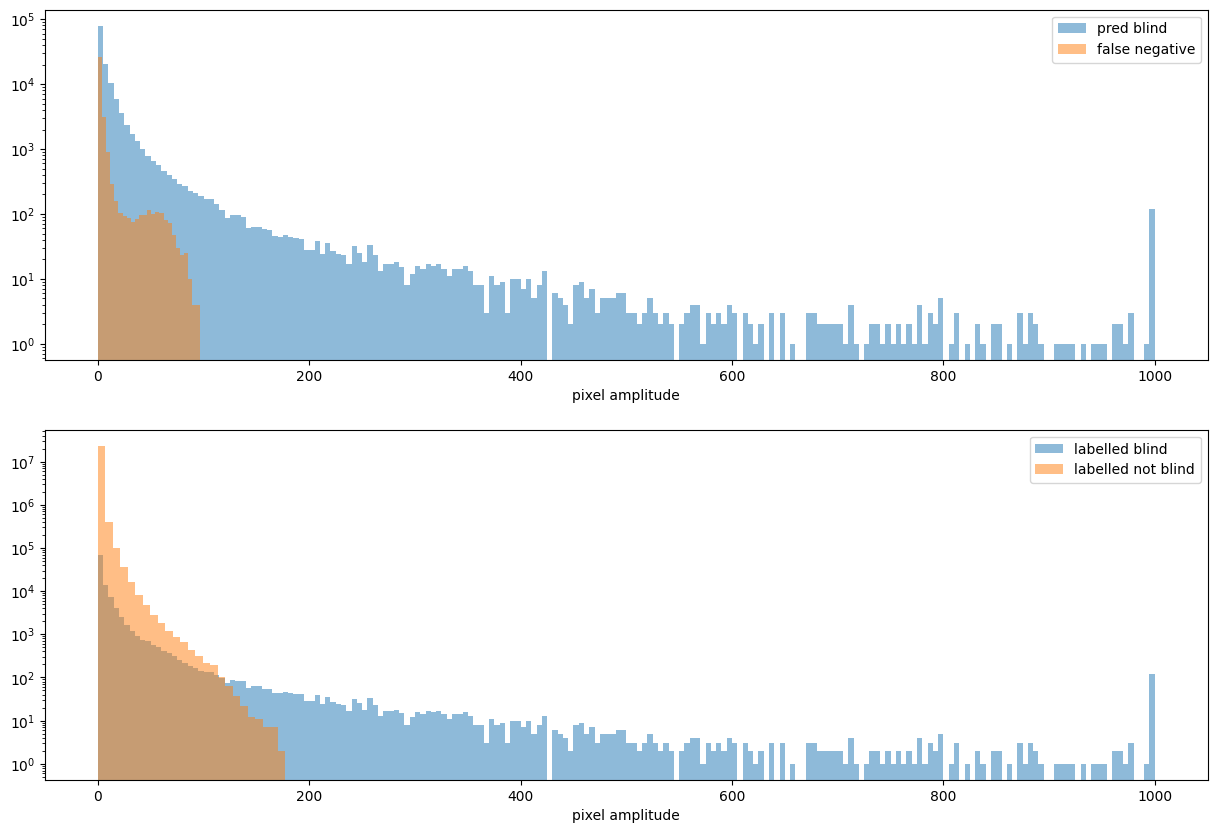

In [35]:
fig, ax = plt.subplots(2,1)

fig.set_figwidth(15)
fig.set_figheight(10)
ax[0].hist(pred_bl.reshape(-1,1), 200, alpha = 0.5, label='pred blind');
ax[0].hist(pred_fn.reshape(-1,1), 25, alpha = 0.5, label='false negative');
#plt.hist(np.concatenate((pred_bl.reshape(-1,1), pred_fn.reshape(-1,1))), 200, histtype='step', ls='dashed')
ax[0].set_yscale('log')
ax[0].set_xlabel('pixel amplitude')
ax[0].legend()


ax[1].hist(lab_bl.reshape(-1,1), 200, alpha=0.5, label='labelled blind');
ax[1].hist(lab_not_bl.reshape(-1,1), 25, alpha=0.5, label='labelled not blind');
ax[1].set_yscale('log')
ax[1].set_xlabel('pixel amplitude')
ax[1].legend()

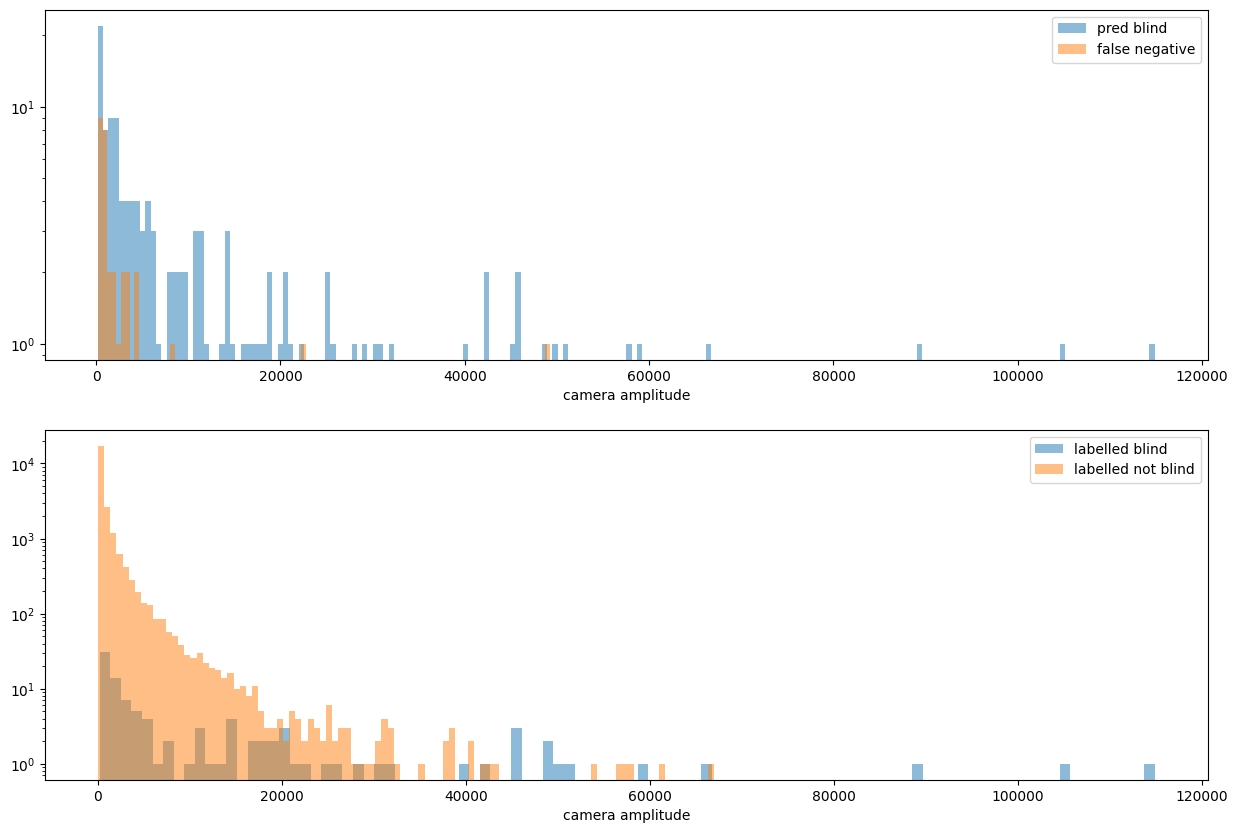

In [36]:
fig, ax = plt.subplots(2,1)
fig.set_figwidth(15)
fig.set_figheight(10)

ax[0].hist(pred_bl_amp.reshape(-1,1), 200, alpha = 0.5, label='pred blind');
ax[0].hist(pred_fn_amp.reshape(-1,1), 100, alpha = 0.5, label='false negative');
#plt.hist(np.concatenate((pred_bl.reshape(-1,1), pred_fn.reshape(-1,1))), 200, histtype='step', ls='dashed')
ax[0].set_yscale('log')
ax[0].set_xlabel('camera amplitude')
ax[0].legend()

ax[1].hist(lab_bl_amp.reshape(-1,1), 100, alpha=0.5, label='labelled blind');
ax[1].hist(lab_not_bl_amp.reshape(-1,1), 100, alpha=0.5, label='labelled not blind');
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')
ax[1].legend()

In [37]:
# img = 100
# plt.imshow(lab_bl[img].reshape(cam_side_length,cam_side_length))
# plt.colorbar()

## Train and Test sets visualization (blind only)

In [38]:
# train_d = data_in[:sep]
# #train_d = MaxAbsScaler().fit_transform(data_in[:sep])

# lab_bl_t = train_d[np.where(train_label==1)]
# lab_not_bl_t = train_d[np.where(train_label==0)]

# lab_not_bl_amp_t = np.sum(lab_not_bl_t, axis=1)
# lab_bl_amp_t = np.sum(lab_bl_t, axis=1)

# lab_not_bl_max_t = np.max(lab_not_bl_t, axis=1)
# lab_bl_max_t = np.max(lab_bl_t, axis=1)

# lab_not_bl_mean_t = np.mean(lab_not_bl_t, axis=1)
# lab_bl_mean_t = np.mean(lab_bl_t, axis=1)

# ratio_bl_lab_t = lab_bl_mean_t/lab_bl_max_t
# ratio_not_bl_lab_t = lab_not_bl_mean_t/lab_not_bl_max_t

# plt.plot(lab_not_bl_max, 1-ratio_not_bl_lab, '.', label='not blind')
# plt.plot(lab_bl_max_t, 1-ratio_bl_lab_t, '.', label='train blind')
# plt.plot(lab_bl_max, 1-ratio_bl_lab, '.', label='test blind')
# plt.xscale('log')
# plt.xlabel('camera maximum')
# plt.ylabel('1-mean/max')
# plt.legend()

In [39]:
save_model = False
if save_model:
    model_json = model.to_json()
    with open('model_highRoc.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('model_highRoc.h5')

In [40]:
# 20 epochs - layers 32 64 128
# previous was:  test_acc: 0.9894444346427917
# predicted : 60
# true positive : 55

# 40 epochs - layers 32 64 128
# test_acc: 0.9893518686294556
# predicted : 69
# true positive : 59

# 20 epochs - layers 64 128 256
# test_acc: 0.9888888597488403
# predicted : 54
# true positive : 49

# 20 epochs - layers 31 93 186
# test_acc: 0.9888888597488403
# predicted : 72
# true positive : 58

# 20 epochs - layers 32 64 128
# test_acc: 0.9893518686294556
# predicted : 63
# true positive : 56

# 20 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9889814853668213
# predicted : 57
# true positive : 51

# 30 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9887962937355042
# predicted : 57
# true positive : 50

# 40 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9892592430114746
# predicted : 58
# true positive : 53

# 50 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9896296262741089
# predicted : 64
# true positive : 58

# 70 epochs - layers 32 64 128 - Dropout 0.3 - loss='categorical_crossentropy'
# test_acc: 0.9900000095367432              # probably starts overfitting
# predicted : 64
# true positive : 60

# 70 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True)
# test_acc: 0.9902777671813965              
# predicted : 69
# true positive : 64
# subsequent data augmentation
# test_acc: 0.9894444346427917              
# predicted : 62
# true positive : 56

# 20 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.988703727722168
# predicted : 52
# true positive : 47

# 40 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9894444346427917
# predicted : 56
# true positive : 53
# precision : 0.9464285714285714
# recall : 0.3231707317073171
# f1 score : 0.4818181818181818

# 40 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9889814853668213
# predicted : 49
# true positive : 47
# precision : 0.9591836734693877
# recall : 0.2865853658536585
# f1 score : 0.44131455399061026
# roc score : 0.6431986626184426

# 70 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9887962937355042              
# predicted : 47
# true positive : 45
# precision : 0.9574468085106383
# recall : 0.27439024390243905
# f1 score : 0.42654028436018954
# roc score : 0.6371011016428328

# 20 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9885185360908508
# predicted : 48
# true positive : 44
# precision : 0.9166666666666666
# recall : 0.2682926829268293
# f1 score : 0.4150943396226415
# roc score : 0.6339583008466414

# 20 epochs - layers 32 64 128 - Dropout 0.3 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.9891666769981384
# predicted : 49
# true positive : 48
# precision : 0.9795918367346939
# recall : 0.2926829268292683
# f1 score : 0.45070422535211263
# roc score : 0.6462944532604409

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.5 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.988611102104187
# predicted : 49
# true positive : 45
# precision : 0.9183673469387755
# recall : 0.27439024390243905
# f1 score : 0.4225352112676057
# roc score : 0.6370070813344463

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - model.add(Dense(64, activation='relu'))
# test_acc: 0.9881481528282166
# predicted : 42
# true positive : 39
# precision : 0.9285714285714286
# recall : 0.23780487804878048
# f1 score : 0.3786407766990291
# roc score : 0.6187614085618104

# 20 epochs - layers 32 64 128 - Dropout 0.3 eliminated(0.3) - loss='categorical_crossentropy' - DataAugmentation 
# test_acc: 0.988703727722168
# predicted : 50
# true positive : 46
# precision : 0.92
# recall : 0.2804878048780488
# f1 score : 0.4299065420560748
# roc score : 0.6400558618222512

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - sigmoid in Conv2D layers
# test_acc: 0.9850925803184509
# predicted : 39
# true positive : 19
# precision : 0.5428571428571428
# recall : 0.11585365853658537
# f1 score : 0.19095477386934676
# roc score : 0.5571746668011999

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - padding='same'
# test_acc: 0.988703727722168
# predicted : 44
# true positive : 43
# precision : 0.9772727272727273
# recall : 0.2621951219512195
# f1 score : 0.41346153846153844
# roc score : 0.6310505508214165

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.9893518686294556
# predicted : 51
# true positive : 50
# precision : 0.9803921568627451
# recall : 0.3048780487804878
# f1 score : 0.4651162790697675
# roc score : 0.6523920142360506

# 100 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.9893518686294556
# predicted : 53
# true positive : 51
# precision : 0.9622641509433962
# recall : 0.31097560975609756
# f1 score : 0.4700460829493088
# roc score : 0.6553937845696622

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9897222518920898
# predicted : 65
# true positive : 59
# precision : 0.9076923076923077
# recall : 0.3597560975609756
# f1 score : 0.5152838427947598
# roc score : 0.679595987855328

# 20 epochs - layers 32 64 128 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9889814853668213
# predicted : 49
# true positive : 47
# precision : 0.9591836734693877
# recall : 0.2865853658536585
# f1 score : 0.44131455399061026
# roc score : 0.6431986626184426

# 20 epochs - layers 32 64 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9880555272102356
# predicted : 47
# true positive : 41
# precision : 0.8723404255319149
# recall : 0.25
# f1 score : 0.3886255924170616
# roc score : 0.6247179390748402

# 20 epochs - layers 32 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9877777695655823
# predicted : 40
# true positive : 36
# precision : 0.9
# recall : 0.21951219512195122
# f1 score : 0.3529411764705882
# roc score : 0.6095680569442024

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='binary_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9888888597488403
# predicted : 52
# true positive : 48
# precision : 0.9230769230769231
# recall : 0.2926829268292683
# f1 score : 0.4444444444444444
# roc score : 0.6461534227978609

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9892592430114746
# predicted : 52
# true positive : 50
# precision : 0.9615384615384616
# recall : 0.3048780487804878
# f1 score : 0.46296296296296297
# roc score : 0.6523450040818572

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9887962937355042
# predicted : 51
# true positive : 47
# precision : 0.9215686274509803
# recall : 0.2865853658536585
# f1 score : 0.43720930232558136
# roc score : 0.643104642310056

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9892592430114746
# predicted : 56
# true positive : 52
# precision : 0.9285714285714286
# recall : 0.3170731707317073
# f1 score : 0.4727272727272727
# roc score : 0.6583485447490804

# 20 epochs - layers 32 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.989120364189148
# predicted : 56
# true positive : 52
# precision : 0.9285714285714286
# recall : 0.3170731707317073
# f1 score : 0.4727272727272727
# roc score : 0.6583485447490804

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9895370602607727
# predicted : 60
# true positive : 56
# precision : 0.9333333333333333
# recall : 0.34146341463414637
# f1 score : 0.5
# roc score : 0.6705436667003

# 20 epochs - layers 32 64 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9888888597488403
# predicted : 51
# true positive : 47
# precision : 0.9215686274509803
# recall : 0.2865853658536585
# f1 score : 0.43720930232558136
# roc score : 0.643104642310056

# 20 epochs - layers 32 32 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.988703727722168
# predicted : 44
# true positive : 43
# precision : 0.9772727272727273
# recall : 0.2621951219512195
# f1 score : 0.41346153846153844
# roc score : 0.6310505508214165

# 20 epochs - layers 32 64 64 128 64 - SpatialDropout2D 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9886574149131775
# predicted : 51
# true positive : 46
# precision : 0.9019607843137255
# recall : 0.2804878048780488
# f1 score : 0.427906976744186
# roc score : 0.6400088516680579

# 20 epochs - layers 32 64 64 128 64 - SpatialDropout2D 0.5 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9886574149131775
# predicted : 47
# true positive : 44
# precision : 0.9361702127659575
# recall : 0.2682926829268293
# f1 score : 0.4170616113744076
# roc score : 0.6340053110008348

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9888888597488403
# predicted : 49
# true positive : 47
# precision : 0.9591836734693877
# recall : 0.2865853658536585
# f1 score : 0.44131455399061026
# roc score : 0.6431986626184426

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9905555844306946
# predicted : 66
# true positive : 64
# precision : 0.9696969696969697
# recall : 0.3902439024390244
# f1 score : 0.5565217391304348
# roc score : 0.6950279309111255

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9901388883590698
# predicted : 66
# true positive : 61
# precision : 0.9242424242424242
# recall : 0.3719512195121951
# f1 score : 0.5304347826086956
# roc score : 0.6857405589851311

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=64 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9895370602607727
# predicted : 59
# true positive : 56
# precision : 0.9491525423728814
# recall : 0.34146341463414637
# f1 score : 0.5022421524663677
# roc score : 0.6705906768544933

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.990231454372406
# predicted : 65
# true positive : 62
# precision : 0.9538461538461539
# recall : 0.3780487804878049
# f1 score : 0.5414847161572053
# roc score : 0.6888833597813225

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9884722232818604
# predicted : 66
# true positive : 53
# precision : 0.803030303030303
# recall : 0.3231707317073171
# f1 score : 0.4608695652173913
# roc score : 0.6609742338491456

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - RobustScaler - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9893518686294556
# predicted : 64
# true positive : 57
# precision : 0.890625
# recall : 0.3475609756097561
# f1 score : 0.4999999999999999
# roc score : 0.6734514167255249

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - RobustScaler - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9902777671813965
# predicted : 64
# true positive : 62
# precision : 0.96875
# recall : 0.3780487804878049
# f1 score : 0.543859649122807
# roc score : 0.6889303699355157

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - camera_normalized - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9899073839187622
# predicted : 55
# true positive : 55
# precision : 1.0
# recall : 0.3353658536585366
# f1 score : 0.502283105022831
# roc score : 0.6676829268292683

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - camera_normalized - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9900925755500793
# predicted : 61
# true positive : 59
# precision : 0.9672131147540983
# recall : 0.3597560975609756
# f1 score : 0.5244444444444444
# roc score : 0.6797840284721012

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - Robust+normalized - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9897222518920898
# predicted : 74
# true positive : 62
# precision : 0.8378378378378378
# recall : 0.3780487804878049
# f1 score : 0.5210084033613445
# roc score : 0.6884602683935827

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - Robust+normalized - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9903703927993774
# predicted : 68
# true positive : 64
# confusion matrix :
# [[10633     4]
#  [  96    64]]
# precision : 0.9411764705882353
# recall : 0.3902439024390244
# f1 score : 0.5517241379310345
# roc score : 0.6949339106027389

############# new dataset ##################################

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9963793158531189
# predicted : 18
# true positive : 18
# precision : 1.0
# recall : 0.3
# f1 score : 0.4615384615384615
# roc score : 0.65

############ dataset 1 + 2 ####################################
# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9963616132736206
# predicted : 29
# true positive : 29
# precision : 1.0
# recall : 0.26126126126126126
# f1 score : 0.41428571428571426
# roc score : 0.6306306306306306

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9963839054107666
# predicted : 30
# true positive : 30
# precision : 1.0
# recall : 0.2702702702702703
# f1 score : 0.4255319148936171
# roc score : 0.6351351351351351

# 50 epochs - layers 32 64 64 128 64 - Dropout 0.5 - RobustScaler - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1
# test_acc: 0.9889285564422607
# predicted : 60
# true positive : 60
# precision : 1.0
# recall : 0.19480519480519481
# f1 score : 0.32608695652173914
# roc score : 0.5974025974025974

# 100/150 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=True) - batch_size=256 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1
# test_acc: 0.9904464483261108
# labelled : 149
# predicted : 43
# true positive : 42
# precision : 0.9767441860465116
# recall : 0.28187919463087246
# f1 score : 0.43749999999999994
# roc score : 0.6408943525412076

# 100 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=True) - batch_size=256 - binary_accuracy - softmax - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1
# test_acc: 0.9899107217788696
# predicted : 38
# true positive : 37
# precision : 0.9736842105263158
# recall : 0.2483221476510067
# f1 score : 0.3957219251336898
# roc score : 0.6241158290512747

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=True) - batch_size=256 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 0.9916517734527588
# labelled : 132
# predicted : 41
# true positive : 40
# precision : 0.975609756097561
# recall : 0.30303030303030304
# f1 score : 0.46242774566473993
# roc score : 0.6514699762350648

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - Robust+normalized - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=True) - batch_size=256 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=150
# test_acc: 0.9912946224212646
# labelled : 119
# predicted : 21
# true positive : 21
# precision : 1.0
# recall : 0.17647058823529413
# f1 score : 0.3
# roc score : 0.5882352941176471

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - Robust+normalized - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=True) - batch_size=256 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 0.9899553656578064
# labelled : 132
# predicted : 19
# true positive : 19
# precision : 1.0
# recall : 0.14393939393939395
# f1 score : 0.25165562913907286
# roc score : 0.571969696969697

# 100 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=True) - batch_size=256 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 0.991428554058075
# predicted : 38
# true positive : 37
# precision : 0.9736842105263158
# recall : 0.2803030303030303
# f1 score : 0.4352941176470588
# roc score : 0.6401063398714284

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=True) - batch_size=256 - metricBinaryCrossentropy - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 0.04096429795026779
# predicted : 31
# true positive : 31
# precision : 1.0
# recall : 0.23484848484848486
# f1 score : 0.3803680981595092
# roc score : 0.6174242424242424

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=True) - batch_size=256 - BinaryIoU(target_class_ids=[0, 1], threshold=0.3) - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 0.9824763536453247
# predicted : 32
# true positive : 32
# precision : 1.0
# recall : 0.24242424242424243
# f1 score : 0.3902439024390244
# roc score : 0.6212121212121212

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=True) - batch_size=256 - BinaryIoU(target_class_ids=[0, 1], threshold=0.7) - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 0.9825640320777893
# predicted : 38
# true positive : 37
# precision : 0.9736842105263158
# recall : 0.2803030303030303
# f1 score : 0.4352941176470588
# roc score : 0.6401063398714284

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=True) - batch_size=256 - FalseNegatives(threshold=0) - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 0.0
# predicted : 33
# true positive : 32
# precision : 0.9696969696969697
# recall : 0.24242424242424243
# f1 score : 0.38787878787878793
# roc score : 0.6211669459320345

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - FalseNegatives(threshold=0.3) - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 91.0
# predicted : 37
# true positive : 36
# precision : 0.972972972972973
# recall : 0.2727272727272727
# f1 score : 0.42603550295857984
# roc score : 0.6363184610835496

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - FalseNegatives(threshold=0.7) - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 109.0
# predicted : 32
# true positive : 31
# precision : 0.96875
# recall : 0.23484848484848486
# f1 score : 0.37804878048780494
# roc score : 0.6173790671441557

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - FalseNegatives(threshold=0.2) - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 80.0
# predicted : 38
# true positive : 35
# precision : 0.9210526315789473
# recall : 0.26515151515151514
# f1 score : 0.4117647058823529
# roc score : 0.6324402317354973

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metricBinaryCrossentropy(from_logits=False) - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 0.03713010624051094
# predicted : 37
# true positive : 36
# precision : 0.972972972972973
# recall : 0.2727272727272727
# f1 score : 0.42603550295857984
# roc score : 0.6363184610835496

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metricBinaryCrossentropy(from_logits=False, label_smoothing=0.2) - sigmoid - DataAugmentation - optimizer='Nadam'
# INVERTED 2 AND 1 ### threshold=100
# test_acc: 0.7361960411071777
# predicted : 39
# true positive : 38
# precision : 0.9743589743589743
# recall : 0.2878787878787879
# f1 score : 0.4444444444444444
# roc score : 0.6438942186593072

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metricBinaryCrossentropy(from_logits=False, label_smoothing=0.2) - sigmoid - DataAugmentation - optimizer='Nadam'
# threshold=100
# test_acc: 1.139198660850525
# labelled : 95
# predicted : 36
# true positive : 33
# precision : 0.9166666666666666
# recall : 0.3473684210526316
# f1 score : 0.5038167938931297
# roc score : 0.673616961030687

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - RobustScaler - validation_split=0.1 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metricBinaryCrossentropy(from_logits=False, label_smoothing=0.2) - sigmoid - DataAugmentation - optimizer='Nadam'
# threshold=100
# test_acc: 1.575400948524475
# predicted : 39
# true positive : 38
# precision : 0.9743589743589743
# recall : 0.4
# f1 score : 0.5671641791044776
# roc score : 0.699977583501457


# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5  - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=AUC - sigmoid - DataAugmentation with shift - optimizer='Nadam'
# threshold=100
# test_acc: 0.9984238743782043
# predicted : 58
# true positive : 49
# confusion matrix :
# [[22296     9]
#  [   46    49]]
# precision : 0.8448275862068966
# recall : 0.5157894736842106
# f1 score : 0.6405228758169935
# roc score : 0.7576929883552189

# 150 epochs - layers 32 64 64 64 128 64 - Dropout 0.5  - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=AUC - sigmoid - DataAugmentation with shift - optimizer='Nadam'
# threshold=100
# test_acc: 0.9981632828712463
# predicted : 55
# true positive : 48
# precision : 0.8727272727272727
# recall : 0.5052631578947369
# f1 score : 0.6399999999999999
# roc score : 0.7524746634575679

# 40 epochs - layers 32 64 64 64 128 64 - Dropout 0.5  - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=AUC - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.005)
# threshold=100
# test_acc: 0.997343897819519
# predicted : 193
# true positive : 54
# confusion matrix :
# [[22166   139]
#  [   41    54]]
# precision : 0.27979274611398963
# recall : 0.5684210526315789
# f1 score : 0.375
# roc score : 0.7810946330183226

# 10 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - normalize_data - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=AUC - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.005)
# threshold=100
# test_acc: 0.9992071390151978
# predicted : 58
# true positive : 47
# false positive : 11
# precision : 0.8103448275862069
# recall : 0.49473684210526314
# f1 score : 0.6143790849673203
# roc score : 0.7471218395686594

# 10 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - normalize_data - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.005)
# threshold=100
# test_acc: [0.9984539  0.60115606]
# predicted : 77
# true positive : 52
# precision : 0.6753246753246753
# recall : 0.5473684210526316
# f1 score : 0.6046511627906976
# roc score : 0.7731237980627426

# 10 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - normalize_data - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: [0.99883544 0.6486487 ]
# predicted : 53
# true positive : 48
# precision : 0.9056603773584906
# recall : 0.5052631578947369
# f1 score : 0.6486486486486487
# roc score : 0.7525194964546538

# 40 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - normalize_data - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=AUC - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: 0.9984925389289856
# predicted : 57
# true positive : 48
# precision : 0.8421052631578947
# recall : 0.5052631578947369
# f1 score : 0.631578947368421
# roc score : 0.7524298304604821

# 40 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - normalize_data - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: [0.9984987  0.61271673]
# predicted : 78
# true positive : 53
# confusion matrix :
# [[22280    25]
#  [   42    53]]
# precision : 0.6794871794871795
# recall : 0.5578947368421052
# f1 score : 0.6127167630057804
# roc score : 0.7783869559574794

# 50 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - normalize_data - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0002)
# threshold=100
# test_acc: [0.998454  0.5964912]
# predicted : 76
# true positive : 51
# confusion matrix :
# [[22280    25]
#  [   44    51]]
# precision : 0.6710526315789473
# recall : 0.5368421052631579
# f1 score : 0.5964912280701754
# roc score : 0.7678606401680057

# 100 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - normalize_data - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0002)
# threshold=100
# test_acc: [0.998634   0.57931036]
# predicted : 50
# true positive : 42
# precision : 0.84
# recall : 0.4421052631578947
# f1 score : 0.5793103448275863
# roc score : 0.720873299590604

# 100 epochs - layers 32 64 64 64 128 64 - Dropout 0.5  - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0002)
# threshold=100
# test_acc: [0.9989025 0.683871 ]
# predicted : 60
# true positive : 53
# confusion matrix :
# [[22298     7]
#  [   42    53]]
# precision : 0.8833333333333333
# recall : 0.5578947368421052
# f1 score : 0.6838709677419355
# roc score : 0.778790452931252

# 40 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: [0.99867857 0.6143791 ]
# predicted : 58
# true positive : 47
# confusion matrix :
# [[22294    11]
#  [   48    47]]
# precision : 0.8103448275862069
# recall : 0.49473684210526314
# f1 score : 0.6143790849673203
# roc score : 0.7471218395686594

# 40 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0007)
# threshold=100
# test_acc: [0.99867857 0.6143791 ]
# predicted : 58
# true positive : 47
# precision : 0.8103448275862069
# recall : 0.49473684210526314
# f1 score : 0.6143790849673203
# roc score : 0.7471218395686594

# 40 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.001)
# threshold=100
# test_acc: [0.9987905  0.64935064]
# predicted : 59
# true positive : 50
# confusion matrix :
# [[22296     9]
#  [   45    50]]
# precision : 0.847457627118644
# recall : 0.5263157894736842
# f1 score : 0.6493506493506493
# roc score : 0.7629561462499557

#### DATASET 1 + 2 + 3

# 40 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: [0.9986279  0.67808217]
# labelled : 171
# predicted : 121 
# confusion matrix :
# [[34207    22]
#  [   72    99]]
# precision : 0.8181818181818182
# recall : 0.5789473684210527
# f1 score : 0.6780821917808219
# roc score : 0.7891523192860471

# 20 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=AUC - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: 0.9989762306213379
# predicted : 162
# true positive : 108
# confusion matrix :
# [[34175    54]
#  [   63   108]]
# precision : 0.6666666666666666
# recall : 0.631578947368421
# f1 score : 0.6486486486486486
# roc score : 0.8150006688695796

# 5 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: [0.9981013 0.6084337]
# predicted : 161
# true positive : 101
# confusion matrix :
# [[34169    60]
#  [   70   101]]
# precision : 0.6273291925465838
# recall : 0.5906432748538012
# f1 score : 0.6084337349397589
# roc score : 0.7944451876328663

# 10 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: [0.9979979 0.6327078]
# predicted : 202
# true positive : 118
# confusion matrix :
# [[34145    84]
#  [   53   118]]
# precision : 0.5841584158415841
# recall : 0.6900584795321637
# f1 score : 0.6327077747989276
# roc score : 0.8438022100544339

# 30 epochs - layers 32 64 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: [0.9985985  0.68211925]
# true positive : 103
# false positive : 29
# precision : 0.7803030303030303
# recall : 0.6023391812865497
# f1 score : 0.6798679867986799
# roc score : 0.8007459732428249

# 10 epochs - layers 32 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: [0.99865687 0.6993464 ]
# predicted : 134
# true positive : 107
# confusion matrix :
# [[34202    27]
#  [   64   107]]
# precision : 0.7985074626865671
# recall : 0.6257309941520468
# f1 score : 0.7016393442622951
# roc score : 0.812471094668708

# 30 epochs - layers 32 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: [0.9988031 0.7172414]
# predicted : 118
# true positive : 104
# confusion matrix :
# [[34215    14]
#  [   67   104]]
# precision : 0.8813559322033898
# recall : 0.6081871345029239
# f1 score : 0.7197231833910035
# roc score : 0.8038890622995206

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: [0.9987887  0.70036095]
# predicted : 106
# confusion matrix :
# [[34220     9]
#  [   74    97]]
# precision : 0.9150943396226415
# recall : 0.5672514619883041
# f1 score : 0.7003610108303249
# roc score : 0.783494263525047

# 25 epochs - layers 32 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100
# test_acc: [0.9988469  0.72852236]
# predicted : 119
# confusion matrix :
# [[34216    13]
#  [   65   106]]
# precision : 0.8907563025210085
# recall : 0.6198830409356725
# f1 score : 0.7310344827586207
# roc score : 0.8097516230124621

# 25 epochs - layers 32 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=F1Score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100 + 4% cut
# test_acc: [0.9990219  0.73255813]
# labelled : 107
# predicted : 65
# confusion matrix :
# [[23491     2]
#  [   44    63]]
# precision : 0.9692307692307692
# recall : 0.5887850467289719
# f1 score : 0.7325581395348836
# roc score : 0.794349957493801

# 25 epochs - layers 32 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=AUC - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100 + 4% cut
# test_acc: 0.9987647533416748
# predicted : 76
# confusion matrix :
# [[23485     8]
#  [   39    68]]
# precision : 0.8947368421052632
# recall : 0.6355140186915887
# f1 score : 0.7431693989071038
# roc score : 0.817586745863055

# 25 epochs - layers 32 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=AUC - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100 + 5% cut
# test_acc: 0.9985485076904297
# labelled : 104
# predicted : 71
# confusion matrix :
# [[23488     8]
#  [   41    63]]
# precision : 0.8873239436619719
# recall : 0.6057692307692307
# f1 score : 0.72
# roc score : 0.80271437364134

# 25 epochs - layers 32 64 64 128 64 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=AUC - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.001)
# threshold=100 + 5% cut
# test_acc: 0.9984660744667053
# predicted : 63
# confusion matrix :
# [[23494     2]
#  [   43    61]]
# precision : 0.9682539682539683
# recall : 0.5865384615384616
# f1 score : 0.7305389221556886
# roc score : 0.793226670333412

# 25 epochs - layers 32 64 64 32 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=f1_score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.001)
# threshold=100 + 5% cut
# test_acc: [0.9988521  0.65822786]
# predicted : 55
# confusion matrix :
# [[23494     2]
#  [   51    53]]
# precision : 0.9636363636363636
# recall : 0.5096153846153846
# f1 score : 0.6666666666666666
# roc score : 0.7547651318718734

# 25 epochs - layers 32 64 128 128 64 32 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=f1_score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.001)
# threshold=100 + 5% cut
# test_acc: [0.99895793 0.726257  ]
# predicted : 75
# confusion matrix :
# [[23486    10]
#  [   39    65]]
# precision : 0.8666666666666667
# recall : 0.625
# f1 score : 0.7262569832402236
# roc score : 0.8122871978209057

# 25 epochs - layers 32 64 128 128 64 32 16 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=f1_score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.001)
# threshold=100 + 5% cut
# test_acc: [0.9975073 0.5584906]
# predicted : 161
# confusion matrix :
# [[23409    87]
#  [   30    74]]
# precision : 0.45962732919254656
# recall : 0.7115384615384616
# f1 score : 0.5584905660377358
# roc score : 0.8539178518111102

# 25 epochs - layers 32 64 128 128 64 32 16 - Dropout 0.3 0.3 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=f1_score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.001)
# threshold=100 + 5% cut
# test_acc: [0.99675864 0.50326794]
# predicted : 200
# confusion matrix :
# [[23373   123]
#  [   27    77]]
# precision : 0.385
# recall : 0.7403846153846154
# f1 score : 0.506578947368421
# roc score : 0.8675748408894477

# 25 epochs - layers 32 64 128 128 64 32 16 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=f1_score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.001)
# threshold=100 + 5% cut
# test_acc: [0.997998  0.6178861]
# predicted : 141
# confusion matrix :
# [[23431    65]
#  [   28    76]]
# precision : 0.5390070921985816
# recall : 0.7307692307692307
# f1 score : 0.6204081632653061
# roc score : 0.8640014012205024

# 25 epochs - layers 32 64 128 128 64 32 16 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=f1_score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0005)
# threshold=100 + 5% cut
# test_acc: [0.9949366  0.39694658]
# predicted : 287
# confusion matrix :
# [[23287   209]
#  [   26    78]]
# precision : 0.27177700348432055
# recall : 0.75
# f1 score : 0.3989769820971867
# roc score : 0.8705524344569289

# 25 epochs - layers 32 64 128 128 64 32 16 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=f1_score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0015)
# threshold=100 + 5% cut
# test_acc: [0.9979983 0.6083333]
# predicted : 135
# confusion matrix :
# [[23434    62]
#  [   31    73]]
# precision : 0.5407407407407407
# recall : 0.7019230769230769
# f1 score : 0.6108786610878661
# roc score : 0.8496421649511536

# 30 epochs - layers 32 64 128 128 64 32 16 - Dropout 0.5 - true normalize - validation_split=0.15 - loss=BinaryCrossentropy(from_logits=False) - batch_size=256 - metric=f1_score - sigmoid - DataAugmentation with shift - optimizer=Nadam(learning_rate=0.0015)
# threshold=100 + 5% cut
# test_acc: [0.99812627 0.6239316 ]
# predicted : 130
# confusion matrix :
# [[23439    57]
#  [   31    73]]
# precision : 0.5615384615384615
# recall : 0.7019230769230769
# f1 score : 0.6239316239316239
# roc score : 0.8497485660407009

In [41]:
# ex = np.where(test_label==1)[0][91]
# predex = model.predict(test_data[ex].reshape(-1, cam_side_length, cam_side_length, 1))
# print(predex, np.around(predex))
# print('cam n° :',ex)

# cam = plt.pcolormesh(test_data[4303].reshape(cam_side_length, cam_side_length)*renormalisation)
# plt.colorbar(cam)  